In [1]:
import os
import sys
import numpy as np
import pandas as pd
import yaml
import json
import itertools
import bayes_opt
from chspy import CubicHermiteSpline
from bayes_opt import BayesianOptimization
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from bayes_opt.util import load_logs
from scipy.optimize import NonlinearConstraint
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from plotly.offline import iplot
from os import PathLike
from pathlib import Path
import scienceplots

from bayes_opt.exception import NotUniqueError
from scipy.optimize import minimize

# Get the path of the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import importlib
import assistive_arm.utils.parametrize_profiles_functions
importlib.reload(assistive_arm.utils.parametrize_profiles_functions)
from assistive_arm.utils.parametrize_profiles_functions import *



# Define the path for saving/loading optimization progress
optimizer_dir = Path(f"../subject_logs/subject_mean_opt_3rep/February_06/Motor/optimizer_logs.json")

# Get save dir
save_dir = optimizer_dir.parent.parent / "plots/optimizer"
save_dir.mkdir(parents=True, exist_ok=True)

In [2]:
pbounds = {
    "force1_end_time_p": (0.0, 1.0),        # End time for force1
    "force1_peak_force_p": (0.0, 1.0),      # Ratio for force1 peak time
    "force2_start_time_p": (0.0, 1.0),      # Start time for force2
    "force2_peak_time_p": (0.0, 1.0),       # Peak time for force2
    "force2_peak_force_p": (0.0, 1.0),      # Peak force for force2
    "force2_end_time_p": (0.0, 1.0)         # End time for force2
}

def objective():
    print("dummy objective")
        
def load_optimizer(kappa, amount=None):
    acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)

    optimizer = BayesianOptimization(
        f=objective(),
        pbounds=pbounds,                   # Parameter bounds
        acquisition_function=acquisition,  # Acquisition function: Upper Confidence Bound
        random_state=0,                    # Random seed accepts integer value and is used for reproducibility.
        verbose=2                          # Verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    )

    # optimizer._gp = GaussianProcessRegressor(
    #         kernel=Matern(length_scale=1.0, length_scale_bounds=(1.5e-1, 1.5e1), nu=1.5),
    #         alpha=1e-3,
    #         normalize_y=True,
    #         n_restarts_optimizer=5,
    #         random_state=0,
    #     )

  
    if os.path.exists(optimizer_dir):
        load_logs(optimizer, logs=[optimizer_dir])
        if optimizer.space:
            # Fit the optimizer
            if amount is None:
                optimizer._gp.fit(optimizer.space.params, optimizer.space.target)  # Refit the GP model
                print(f"Loaded optimization progress from file. {len(optimizer.space)} evaluations loaded.")
            else: 
                optimizer._gp.fit(optimizer.space.params[:amount], optimizer.space.target[:amount])  # Refit the GP model
                print(f"Loaded optimization progress from file. {len(optimizer.space.params[:amount])} evaluations loaded.")
            
        else:
            print("No evaluations found in the log. Starting a new optimization.")
    else:
        print("No saved progress found. Starting a new optimization.")

    return optimizer
 

In [3]:

optimizer = load_optimizer(kappa=2.5)

dummy objective
Loaded optimization progress from file. 76 evaluations loaded.


dummy objective
Loaded optimization progress from file. 70 evaluations loaded.
dummy objective
Loaded optimization progress from file. 71 evaluations loaded.
dummy objective
Loaded optimization progress from file. 209 evaluations loaded.
dummy objective


/Users/nathanirniger/opt/anaconda3/envs/opens/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



Loaded optimization progress from file. 76 evaluations loaded.


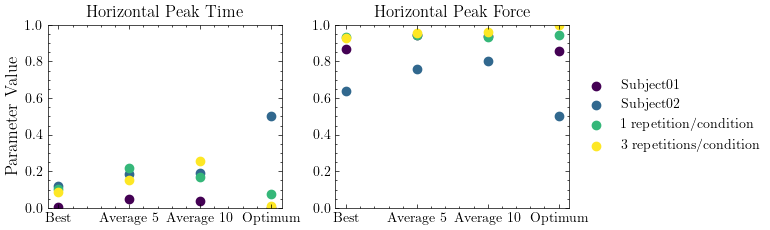

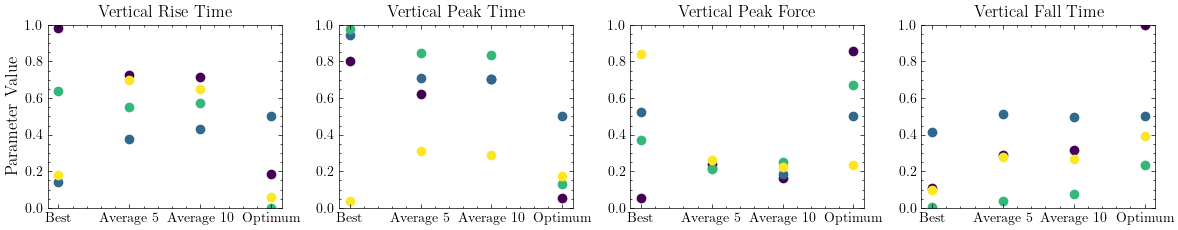

In [77]:
optimizer_dirs = {}
optimizer_dirs["Subject01"] = Path(f"../subject_logs/subject_Optimization_Jae/February_24/Motor/optimizer_logs.json")
optimizer_dirs["Subject02"] = Path(f"../subject_logs/subject_Optimization_Dom/February_21/Motor/optimizer_logs.json")
optimizer_dirs["1 repetition/condition"] = Path(f"../subject_logs/subject_mean_opt_1rep/February_04/Motor/optimizer_logs.json")
optimizer_dirs["3 repetitions/condition"] = Path(f"../subject_logs/subject_mean_opt_3rep/February_06/Motor/optimizer_logs.json")

def negative_gp_prediction(params, optimizer):
    """Returns the negative predicted mean of the GP model for minimization."""
    params = np.array(params).reshape(1, -1)  # Ensure shape
    mean, _ = optimizer._gp.predict(params, return_std=True)
    return -mean.item()  # Negative for maximization


avg_top_5 = {}
avg_top_10 = {}
best = {}
optimum = {}

for key in optimizer_dirs.keys():
    optimizer_dir = optimizer_dirs[key]

    optimizer = load_optimizer(kappa=2.5)
    
    # Get the averaged parameters of the best, top 5 and 10 evaluations
    avg_top_5[key] = {}
    avg_top_10[key] = {}
    best[key] = {}
    optimum[key] = {}

    # get the ones with the highest target value
    top_5 = optimizer.space.target.argsort()[-5:][::-1]
    top_10 = optimizer.space.target.argsort()[-10:][::-1]
    best_index = optimizer.space.target.argmax()

    # Get the averaged parameters of the best, top 5 and 10 evaluations
    avg_top_5[key] = optimizer.space.params[top_5].mean(axis=0)
    avg_top_10[key] = optimizer.space.params[top_10].mean(axis=0)
    best[key] = optimizer.space.params[best_index]

    # Get parameter bounds in the correct format
    bounds = [pbounds[p] for p in optimizer.space.keys]
    # Find the predicted maximum
    res = minimize(negative_gp_prediction, x0=np.mean(bounds, axis=1), bounds=bounds, args=(optimizer), method="L-BFGS-B")
    # Extract results
    optimal_predicted_params = dict(zip(optimizer.space.keys, res.x))
    # Convert to array
    optimal_predicted_params = np.array([optimal_predicted_params[p] for p in pbounds.keys()])

    optimum[key] = optimal_predicted_params
    


# Plot the results
# for i, key in enumerate(optimizer_dirs.keys()):
#     fig, ax = plt.subplots(1, 1, figsize=(6, 4))
#     colors = cm.viridis(np.linspace(0, 1, len(optimizer_dirs)))
#     # Plot the best, top 5 and top 10
#     ax.plot(best[key], label=f"{key} best", color=colors[i], marker="o")
#     ax.plot(avg_top_5[key], label=f"{key} top 5 avg", color=colors[i], marker="x")
#     ax.plot(avg_top_10[key], label=f"{key} top 10 avg", color=colors[i], marker="s")
#     ax.plot(optimum[key].values(), label=f"{key} optimum", color=colors[i], marker="^")
#     ax.set_xlabel("Parameter")
#     ax.set_ylabel("Value")
#     ax.set_title(f"Optimization results for {key}")
#     ax.legend()
#     plt.tight_layout()
#     plt.show()


# Plot create one plot for each dictionary

# plot all best
def plot_dict(data_dict, title):
    plt.style.use('science')
    fig, ax = plt.subplots(figsize=(8, 4))
    colors = cm.viridis(np.linspace(0, 1, len(data_dict)))
    
    x_labels = {
        1: "Horizontal End Time",
        2: "Horizontal Peak Force",
        3: "Vertical Start Time",
        4: "Vertical Rise Time",
        5: "Vertical Peak Force",
        6: "Vertical Fall Time",
    }
    
    x_ticks = list(x_labels.keys())
    x_tick_labels = list(x_labels.values())

    for i, (key, values) in enumerate(data_dict.items()):
        ax.scatter(x_ticks, values, label=key, color=colors[i])  # Use scatter instead of plot

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, rotation=45, ha="right")
    ax.set_xlabel("Parameter")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# plot_dict(best, "Best parameters")
# plot_dict(avg_top_5, "Top 5 average parameters")
# plot_dict(avg_top_10, "Top 10 average parameters")
# plot_dict(optimum, "Optimum parameters")


def plot_parameters(best, avg_top_5, avg_top_10, optimum, title_prefix="Parameter"):
    x_labels = ["Best", "Average 5", "Average 10", "Optimum"]
    num_parameters = 6  # Since there are six parameters

    parameter_names = {
        0: "Horizontal Peak Time",
        1: "Horizontal Peak Force",
        2: "Vertical Start Time",
        3: "Vertical Peak Time",
        4: "Vertical Peak Force",
        5: "Vertical End Time",
    }

    for param_idx in range(num_parameters):
        plt.figure(figsize=(6, 4))
        colors = cm.viridis(np.linspace(0, 1, len(best)))

        for i, key in enumerate(best.keys()):
            y_values = [
                best[key][param_idx],
                avg_top_5[key][param_idx],
                avg_top_10[key][param_idx],
                optimum[key][param_idx]
            ]
            x_positions = np.arange(len(x_labels))  # x-axis positions
            plt.scatter(x_positions, y_values, label=key, color=colors[i])

        plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
        plt.xlabel("Optimization Strategy")
        plt.ylabel(f"Value of {parameter_names[param_idx]}")
        plt.ylim(0, 1)  # Normalize values between 0 and 1
        plt.title(f"{title_prefix} {param_idx+1}: {parameter_names[param_idx]}")
        plt.legend()
        plt.tight_layout()
        plt.show()

# plot_parameters(best, avg_top_5, avg_top_10, optimum, title_prefix="Parameter")


def plot_separated_parameters(best, avg_top_5, avg_top_10, optimum, title_prefix="Parameter"):
    x_labels = ["Best", "Average 5", "Average 10", "Optimum"]
    
    # Define parameter indices for horizontal and vertical parameters
    horizontal_params = {0: "Horizontal Peak Time", 1: "Horizontal Peak Force"}
    vertical_params = {
        2: "Vertical Rise Time",
        3: "Vertical Peak Time",
        4: "Vertical Peak Force",
        5: "Vertical Fall Time"
    }
    
    colors = cm.viridis(np.linspace(0, 1, len(best)))

    # --- Plot horizontal parameters ---
    fig1, axes1 = plt.subplots(1, 2, figsize=(7.9, 2.5))  
    for ax, (param_idx, param_name) in zip(axes1, horizontal_params.items()):
        for i, key in enumerate(best.keys()):
            y_values = [
                best[key][param_idx],
                avg_top_5[key][param_idx],
                avg_top_10[key][param_idx],
                optimum[key][param_idx]
            ]
            x_positions = np.arange(len(x_labels))
            ax.scatter(x_positions, y_values, label=key, color=colors[i])

        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels)
        # ax.set_xlabel("Optimization Strategy")
        if ax == axes1[0]:
            ax.set_ylabel(f"Parameter Value", fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_title(param_name)

    # Add legend to the right of the segond plot
    axes1[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

    # axes1[0].legend()
    # fig1.suptitle("Horizontal Parameters")
    plt.tight_layout()
    # plt.show()
    plt.savefig(save_dir / "horizontal_parameters.pdf")

    # --- Plot vertical parameters ---
    fig2, axes2 = plt.subplots(1, 4, figsize=(12, 2.5))  
    axes2 = axes2.flatten()  

    for ax, (param_idx, param_name) in zip(axes2, vertical_params.items()):
        for i, key in enumerate(best.keys()):
            y_values = [
                best[key][param_idx],
                avg_top_5[key][param_idx],
                avg_top_10[key][param_idx],
                optimum[key][param_idx]
            ]
            x_positions = np.arange(len(x_labels))
            ax.scatter(x_positions, y_values, label=key, color=colors[i])

        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels)
        # ax.set_xlabel("Optimization Strategy")
        if ax == axes2[0]:
            ax.set_ylabel(f"Parameter Value", fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_title(param_name)

    # axes2[0].legend()
    # fig2.suptitle("Vertical Parameters")
    plt.tight_layout()
    plt.savefig(save_dir / "vertical_parameters.pdf")
    # plt.show()


plot_separated_parameters(best, avg_top_5, avg_top_10, optimum, title_prefix="Parameter")


In [8]:
best_params = optimizer.max["params"]
print(f"Best parameters: {best_params}")

Best parameters: {'force1_end_time_p': 0.11827442586893322, 'force1_peak_force_p': 0.6399210213275238, 'force2_end_time_p': 0.1433532874090464, 'force2_peak_force_p': 0.9446689170495839, 'force2_peak_time_p': 0.5218483217500717, 'force2_start_time_p': 0.4146619399905236}


In [5]:
# Find the predicted maximum

def negative_gp_prediction(params, optimizer):
    """Returns the negative predicted mean of the GP model for minimization."""
    params = np.array(params).reshape(1, -1)  # Ensure shape
    mean, _ = optimizer._gp.predict(params, return_std=True)
    return -mean.item()  # Negative for maximization

# Get parameter bounds in the correct format
bounds = [pbounds[p] for p in optimizer.space.keys]

# Find the predicted maximum
res = minimize(negative_gp_prediction, x0=np.mean(bounds, axis=1), bounds=bounds, args=(optimizer), method="L-BFGS-B")

# Extract results
optimal_predicted_params = dict(zip(optimizer.space.keys, res.x))
optimal_predicted_score = -res.fun  # Flip sign back

print("Optimal Predicted Parameters (from GP model):", optimal_predicted_params)
print("Optimal Predicted Score:", optimal_predicted_score)


force1_end_time_p = optimal_predicted_params["force1_end_time_p"]
force1_peak_force_p = optimal_predicted_params["force1_peak_force_p"]
force2_start_time_p = optimal_predicted_params["force2_start_time_p"]
force2_peak_time_p = optimal_predicted_params["force2_peak_time_p"]
force2_peak_force_p = optimal_predicted_params["force2_peak_force_p"]
force2_end_time_p = optimal_predicted_params["force2_end_time_p"]

# Plot the profile and save it to the validation_profiles directory
force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time = percentage_to_actual(force1_end_time_p, force1_peak_force_p, force2_start_time_p, force2_peak_time_p, force2_peak_force_p, force2_end_time_p, 400)
# force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time = percentage_to_actual_2(force1_end_time_p, force1_peak_force_p, force2_start_time_p, force2_peak_time_p, force2_peak_force_p, force2_end_time_p, 400)
# force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time = percentage_to_actual_3(force1_end_time_p, force1_peak_force_p, force2_start_time_p, force2_peak_time_p, force2_peak_force_p, force2_end_time_p, 400)

profile_name = f"t11_{int(np.round(force1_end_time))}_f11_{int(np.round(force1_peak_force))}_t21_{int(np.round(force2_start_time))}_t22_{int(np.round(force2_peak_time))}_t23_{int(np.round(force2_end_time))}_f21_{int(np.round(force2_peak_force))}_Profile_Optimum"

base_profile = get_profile(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time, 400)
# base_profile = get_profile_2(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time, 400)

validation_profiles_dir = optimizer_dir.parent.parent / "Validation_profiles"
validation_profiles_dir.mkdir(parents=True, exist_ok=True)

# Save as csv
base_profile.to_csv(validation_profiles_dir / f"{profile_name}.csv", index=False)
plot_force_profile(base_profile, validation_profiles_dir, profile_name)


Optimal Predicted Parameters (from GP model): {'force1_end_time_p': 0.5676332061161764, 'force1_peak_force_p': 0.9255200703542047, 'force2_end_time_p': 0.07124498202133253, 'force2_peak_force_p': 0.08751184354126357, 'force2_peak_time_p': 0.019959690797436133, 'force2_start_time_p': 0.8324365184367151}
Optimal Predicted Score: 0.22642724573952822


In [14]:
# iterate through all the sampled parameters and plot the profiles on the same plot
# Get the sampled parameters
sampled_params = optimizer.space.params
sampled_params = np.array(sampled_params)

# Iterate through the sampled parameters and convert them to actual values
sampled_profiles = []

for i, params in enumerate(sampled_params):
    force1_end_time_p = params[0]
    force1_peak_force_p = params[1]
    force2_start_time_p = params[2]
    force2_peak_time_p = params[3]
    force2_peak_force_p = params[4]
    force2_end_time_p = params[5]

    # Convert to actual values
    force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time = percentage_to_actual(force1_end_time_p, force1_peak_force_p, force2_start_time_p, force2_peak_time_p, force2_peak_force_p, force2_end_time_p, 400)
    # force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time = percentage_to_actual_3(force1_end_time_p, force1_peak_force_p, force2_start_time_p, force2_peak_time_p, force2_peak_force_p, force2_end_time_p, 400)

    # Get the profile
    profile = get_profile(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time, 400)
    # profile = get_profile_3(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time)

    sampled_profiles.append(profile)



def plot_all_profiles(profiles, save_dir, profile_name):
    plt.style.use('science')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))  # two small side-by-side plots

    colors = cm.viridis(np.linspace(0, 1, len(profiles)))

    for i, profile in enumerate(profiles):
        profile["STS"] = np.linspace(0, 100, len(profile))

        ax1.plot(profile["STS"], profile["force_Y"], color=colors[i], linewidth=1)
        ax2.plot(profile["STS"], profile["force_X"], color=colors[i], linewidth=1)

    ax1.set_ylabel("Vertical Force $[N]$")
    ax1.set_xlabel("STS $[\%]$")

    ax2.set_ylabel("Horizontal Force $[N]$")
    ax2.set_xlabel("STS $[\%]$")

    plt.tight_layout()

    if save_dir is not None:
        fig.savefig(save_dir / f"{profile_name}_sampled_profiles.pdf", format="pdf")
        # save as svg
        fig.savefig(save_dir / f"{profile_name}_sampled_profiles.svg", format="svg")
        plt.close()
    else:
        plt.show()

plot_all_profiles(sampled_profiles, validation_profiles_dir, profile_name)


In [8]:
# Plots all unique score surfaces as a lower triangular grid
plot_names = {
                "force1_end_time_p": "Horizontal Peak Time",
                "force1_peak_force_p": "Horizontal Peak Force",
                "force2_start_time_p": "Vertical Start Time",
                "force2_peak_time_p": "Vertical Peak Time",
                "force2_peak_force_p": "Vertical Peak Force",
                "force2_end_time_p": "Vertical End Time",
            }


plot_colors = {
                "force1_end_time_p": "limegreen",
                "force1_peak_force_p": "limegreen",
                "force2_start_time_p": "darkgreen",
                "force2_peak_time_p": "darkgreen",
                "force2_peak_force_p": "darkgreen",
                "force2_end_time_p": "darkgreen",
            }

def plot_score_surfaces(optimizer, pbounds, amount, save_pth):

    # Find the predicted maximum
    res = minimize(negative_gp_prediction, x0=np.mean(bounds, axis=1), bounds=bounds, args=(optimizer), method="L-BFGS-B")

    # Extract results
    optimal_predicted_params = dict(zip(optimizer.space.keys, res.x))
    optimal_predicted_score = -res.fun  # Flip sign back

    param_names = list(pbounds.keys())
    n_params = len(param_names)
    
    # Create figure with subplots (lower triangular layout)
    fig, axes = plt.subplots(n_params, n_params, figsize=(4 * n_params, 4 * n_params), sharex="col", sharey="row")

    plt.style.use('science')
    x_vals_dict = {p: np.linspace(pbounds[p][0], pbounds[p][1], 50) for p in param_names}

    vmin, vmax = 0, 0.3
    norm = Normalize(vmin=vmin, vmax=vmax)

    # Iterate over lower triangle indices
    for i in range(n_params):
        for j in range(i):  # Only lower triangle (j < i)
            param_x, param_y = param_names[j], param_names[i]
            x_vals, y_vals = x_vals_dict[param_x], x_vals_dict[param_y]
            scores = np.zeros((len(x_vals), len(y_vals)))
            # param_values = {
            #     "force1_end_time_p": 0.5,
            #     "force1_peak_force_p": 0.5,
            #     "force2_start_time_p": 0.5,
            #     "force2_peak_time_p": 0.5,
            #     "force2_peak_force_p": 0.5,
            #     "force2_end_time_p": 0.5,
            # }
            param_values = {
                "force1_end_time_p": optimal_predicted_params["force1_end_time_p"],
                "force1_peak_force_p": optimal_predicted_params["force1_peak_force_p"],
                "force2_start_time_p": optimal_predicted_params["force2_start_time_p"],
                "force2_peak_time_p": optimal_predicted_params["force2_peak_time_p"],
                "force2_peak_force_p": optimal_predicted_params["force2_peak_force_p"],
                "force2_end_time_p": optimal_predicted_params["force2_end_time_p"],
            }

            for xi, x in enumerate(x_vals):
                for yi, y in enumerate(y_vals):
                    param_values[param_x] = x
                    param_values[param_y] = y

                    param_list = [
                        param_values["force1_end_time_p"],
                        param_values["force1_peak_force_p"],
                        param_values["force2_end_time_p"],
                        param_values["force2_peak_force_p"],
                        param_values["force2_peak_time_p"],
                        param_values["force2_start_time_p"],
                    ]

                    mean, std = optimizer._gp.predict([param_list], return_std=True)
                    scores[xi, yi] = mean.item()  # Extract scalar

            # Extract evaluated points
            evaluated_x = [res["params"][param_x] for res in optimizer.res]
            evaluated_y = [res["params"][param_y] for res in optimizer.res]
            evaluated_scores = [res["target"] for res in optimizer.res]

            # Only take the ones that were used to fit the GP
            evaluated_x = evaluated_x[:amount]
            evaluated_y = evaluated_y[:amount]
            evaluated_scores = evaluated_scores[:amount]

            best_params = optimizer.max["params"]

            # Best found score
            best_x, best_y = best_params[param_x], best_params[param_y]
            best_score = optimizer.max["target"]

            # Optimum in the predicted surface
            best_pred_x, best_pred_y = optimal_predicted_params[param_x], optimal_predicted_params[param_y]
            best_pred_score = optimal_predicted_score


            # Plot in the appropriate subplot
            ax = axes[i, j]
            contour = ax.contourf(x_vals, y_vals, scores.T, cmap="viridis", levels=50, vmin=vmin, vmax=vmax)
            ax.scatter(evaluated_x, evaluated_y, c=evaluated_scores, cmap="viridis", vmin=vmin, vmax=vmax, edgecolors="k", s=50)
            ax.scatter(best_x, best_y, color="red", edgecolors="gold", marker="*", s=150, label=f"Best: {best_score:.2f}")
            ax.scatter(best_pred_x, best_pred_y, color="blue", edgecolors="cyan", marker="P", s=150, label=f"Best Predicted: {best_pred_score:.2f}")

            # Labels
            if i == n_params - 1:
                ax.set_xlabel(plot_names[param_x], fontsize=28, color=plot_colors[param_x]) #bbox=dict(facecolor=plot_colors[param_x], edgecolor='none')) 
            if j == 0:
                ax.set_ylabel(plot_names[param_y], fontsize=28, color=plot_colors[param_y]) #bbox=dict(facecolor=plot_colors[param_y], edgecolor='none'))

            # Legend if i and j == 0
            if i == n_params - 1 and j == 0:
                ax.legend(loc="lower right", fontsize=14, frameon=True, facecolor="white", framealpha=0.4)

            if i == n_params - 2 and j == 3:
                cbar_ax = fig.add_axes([ax.get_position().x1 + 0.04, ax.get_position().y0 - 0.049, 0.02, ax.get_position().height + 0.041])
                # cbar_ax = fig.add_axes([ax.get_position().x1 + 0.04, ax.get_position().y0 - 0.051, 0.02, ax.get_position().height + 0.033])
                
                sm = cm.ScalarMappable(cmap="viridis", norm=norm)
                sm.set_array([])  # Required for colorbar to work properly

                # Create color bar using the same contour object
                cbar = plt.colorbar(sm, cax=cbar_ax)  
                cbar.set_label("Score", fontsize=20)


    # Hide upper triangle subplots
    for i in range(n_params):
        for j in range(i, n_params):
            axes[i, j].set_visible(False)

    # Adjust layout and save
    plt.tight_layout()
    save_path = os.path.join(save_pth, f"score_surfaces_grid_{amount}_all.pdf")
    # plt.show()
    plt.savefig(save_path, format="pdf")

    # save as svg
    save_path_svg = os.path.join(save_pth, f"score_surfaces_grid_{amount}_all.svg")
    plt.savefig(save_path_svg, format="svg")
    plt.close(fig)


for amount in range(1,8):
    amount*=10
    optimizer = load_optimizer(kappa=2.5, amount=amount)

    plot_score_surfaces(optimizer, pbounds, amount, save_dir)



dummy objective
Loaded optimization progress from file. 10 evaluations loaded.


/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_47099/2452126755.py:138: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



dummy objective
Loaded optimization progress from file. 20 evaluations loaded.


/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_47099/2452126755.py:138: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



dummy objective
Loaded optimization progress from file. 30 evaluations loaded.


/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_47099/2452126755.py:138: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



dummy objective
Loaded optimization progress from file. 40 evaluations loaded.


/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_47099/2452126755.py:138: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



dummy objective
Loaded optimization progress from file. 50 evaluations loaded.


/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_47099/2452126755.py:138: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



dummy objective
Loaded optimization progress from file. 60 evaluations loaded.


/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_47099/2452126755.py:138: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



dummy objective
Loaded optimization progress from file. 70 evaluations loaded.


/var/folders/2r/11xslhkj4dv68497dqcmks200000gn/T/ipykernel_47099/2452126755.py:138: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [13]:
# Plot all the parameter values over time

def plot_parameter_values(optimizer, save_pth):
    param_names = list(optimizer.space.keys)
    n_params = len(param_names)
    n_evals = len(optimizer.space)

    fig, axes = plt.subplots(n_params, 1, figsize=(6, 2 * n_params), sharex=True)
    plt.style.use('science')
    

    for i, param in enumerate(param_names):
        param_values = [res["params"][param] for res in optimizer.res]
        axes[i].plot(range(n_evals), param_values, label=param)
        axes[i].set_ylabel(param)

    axes[-1].set_xlabel("Evaluation Number")
    plt.tight_layout()
    save_path = os.path.join(save_pth, "parameter_values.png")
    plt.savefig(save_path, dpi=500, bbox_inches="tight")
    plt.close(fig)
    # plt.show()

# Plot the distribution of parameter values
def plot_parameter_value_distribution(optimizer, save_pth):
    param_names = list(optimizer.space.keys)
    n_params = len(param_names)

    fig, axes = plt.subplots(n_params, 1, figsize=(6, 2 * n_params), sharex=True)
    plt.style.use('science')

    for i, param in enumerate(param_names):
        param_values = [res["params"][param] for res in optimizer.res]
        axes[i].hist(param_values, bins=20, alpha=0.7, label=param)
        axes[i].set_ylabel(param)

    axes[-1].set_xlabel("Parameter Value")
    plt.tight_layout()
    save_path = os.path.join(save_pth, "parameter_value_distribution.png")
    plt.savefig(save_path, dpi=500, bbox_inches="tight")
    plt.close(fig)
    # plt.show()

# plot the distribution as percentage and have the occurence as percentage so all bins add to 100
def plot_parameter_value_distribution_percentage(otpimizer, save_dir):
    param_names = list(optimizer.space.keys)
    n_params = len(param_names)

    fig, axes = plt.subplots(n_params, 1, figsize=(6, 2 * n_params), sharex=True)
    plt.style.use('science')

    for i, param in enumerate(param_names):
        param_values = [res["params"][param] for res in optimizer.res]
        hist, bins = np.histogram(param_values, bins=20)
        hist = hist / np.sum(hist) * 100
        axes[i].bar(bins[:-1], hist, width=np.diff(bins), alpha=0.7, label=param)
        axes[i].set_ylabel(param)

    axes[-1].set_xlabel("Parameter Value")
    plt.tight_layout()
    save_path = os.path.join(save_dir, "parameter_value_distribution_percentage.png")
    plt.savefig(save_path, dpi=500, bbox_inches="tight")
    plt.close(fig)
    # plt.show()

# Plot the scores over time
def plot_scores(optimizer, save_pth):
    scores = [res["target"] for res in optimizer.res]
    n_evals = len(optimizer.space)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plt.style.use('science')
    ax.plot(range(n_evals), scores, label="Scores")
    ax.set_xlabel("Evaluation Number")
    ax.set_ylabel("Score")
    plt.tight_layout()
    save_path = os.path.join(save_pth, "scores.png")
    plt.savefig(save_path, dpi=500, bbox_inches="tight")
    plt.close(fig)
    # plt.show()

plot_parameter_values(optimizer, save_dir) 
# plot_parameter_value_distribution(optimizer, save_dir)
plot_parameter_value_distribution_percentage(optimizer, save_dir)
plot_scores(optimizer, save_dir)
    

dummy objective
Loaded optimization progress from file. 1 evaluations loaded.
Optimal Predicted Parameters (from GP model): {'force1_end_time_p': 0.5, 'force1_peak_force_p': 0.5, 'force2_end_time_p': 0.5, 'force2_peak_force_p': 0.5, 'force2_peak_time_p': 0.5, 'force2_start_time_p': 0.5}
Optimal Predicted Score: 0.16112602390719868
dummy objective
Loaded optimization progress from file. 2 evaluations loaded.
Optimal Predicted Parameters (from GP model): {'force1_end_time_p': 0.5, 'force1_peak_force_p': 0.5, 'force2_end_time_p': 0.5, 'force2_peak_force_p': 0.5, 'force2_peak_time_p': 0.5, 'force2_start_time_p': 0.5}
Optimal Predicted Score: 0.08101634598125992
dummy objective
Loaded optimization progress from file. 3 evaluations loaded.
Optimal Predicted Parameters (from GP model): {'force1_end_time_p': 0.8336820790778599, 'force1_peak_force_p': 1.0, 'force2_end_time_p': 1.0, 'force2_peak_force_p': 0.5296831053847186, 'force2_peak_time_p': 0.6914813080068004, 'force2_start_time_p': 0.2000

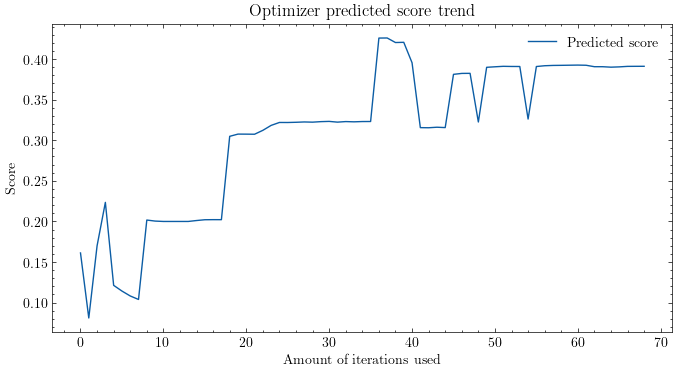

In [54]:
# Find the predicted maximum

best_param = {}
best_param["force1_end_time_p"] = []
best_param["force1_peak_force_p"] = []
best_param["force2_start_time_p"] = []
best_param["force2_peak_time_p"] = []
best_param["force2_peak_force_p"] = []
best_param["force2_end_time_p"] = []
maxima = []

for amount in range(1,70):
    optimizer = load_optimizer(kappa=2.5, amount=amount)

    def negative_gp_prediction(params, optimizer):
        """Returns the negative predicted mean of the GP model for minimization."""
        params = np.array(params).reshape(1, -1)  # Ensure shape
        mean, _ = optimizer._gp.predict(params, return_std=True)
        return -mean.item()  # Negative for maximization

    # Get parameter bounds in the correct format
    bounds = [pbounds[p] for p in optimizer.space.keys]

    # Find the predicted maximum
    res = minimize(negative_gp_prediction, x0=np.mean(bounds, axis=1), bounds=bounds, args=(optimizer), method="L-BFGS-B")

    # Extract results
    optimal_predicted_params = dict(zip(optimizer.space.keys, res.x))
    optimal_predicted_score = -res.fun  # Flip sign back

    print("Optimal Predicted Parameters (from GP model):", optimal_predicted_params)
    print("Optimal Predicted Score:", optimal_predicted_score)


    maxima.append(optimal_predicted_score)

    force1_end_time_p = optimal_predicted_params["force1_end_time_p"]
    force1_peak_force_p = optimal_predicted_params["force1_peak_force_p"]
    force2_start_time_p = optimal_predicted_params["force2_start_time_p"]
    force2_peak_time_p = optimal_predicted_params["force2_peak_time_p"]
    force2_peak_force_p = optimal_predicted_params["force2_peak_force_p"]
    force2_end_time_p = optimal_predicted_params["force2_end_time_p"]

    best_param["force1_end_time_p"].append(force1_end_time_p)
    best_param["force1_peak_force_p"].append(force1_peak_force_p)
    best_param["force2_start_time_p"].append(force2_start_time_p)
    best_param["force2_peak_time_p"].append(force2_peak_time_p)
    best_param["force2_peak_force_p"].append(force2_peak_force_p)
    best_param["force2_end_time_p"].append(force2_end_time_p)


    # Plot the profile and save it to the validation_profiles directory
    # force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time = percentage_to_actual_3(force1_end_time_p, force1_peak_force_p, force2_start_time_p, force2_peak_time_p, force2_peak_force_p, force2_end_time_p, 100)

    # profile_name = f"t11_{int(np.round(force1_end_time))}_f11_{int(np.round(force1_peak_force))}_t21_{int(np.round(force2_start_time))}_t22_{int(np.round(force2_peak_time))}_t23_{int(np.round(force2_end_time))}_f21_{int(np.round(force2_peak_force))}_Profile_Optimum"

    # base_profile = get_profile_2(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time, 400)

    # validation_profiles_dir = optimizer_dir.parent.parent / "Validation_profiles"
    # validation_profiles_dir.mkdir(parents=True, exist_ok=True)

    # # Save as csv
    # base_profile.to_csv(validation_profiles_dir / f"{profile_name}.csv", index=False)
    # plot_force_profile(base_profile, validation_profiles_dir, profile_name)

# print(maxima)
param_names = list(optimizer.space.keys)
n_params = len(param_names)
n_evals = len(optimizer.space)

fig, axes = plt.subplots(n_params, 1, figsize=(6, 2 * n_params), sharex=True)
plt.style.use('science')

for i, param in enumerate(param_names):
    axes[i].plot(best_param[param], label=param)
    axes[i].set_ylabel(param)
    axes[i].set_ylim([0, 1])

axes[-1].set_xlabel("Evaluation Number")
plt.tight_layout()
save_path = os.path.join(save_dir, "best_values_over_time.png")
plt.savefig(save_path, dpi=500, bbox_inches="tight")
plt.close(fig)
# plt.show()



# Plot the maxima over time
plt.figure(figsize=(8, 4))
plt.plot(maxima, label="Predicted score")
plt.xlabel("Amount of iterations used")
plt.ylabel("Score")
plt.title("Optimizer predicted score trend")
plt.legend()
save_path = os.path.join(save_dir, "best_score_over_time.png")
plt.savefig(save_path, dpi=500)
# plt.show()


In [ ]:
# Plots all unique score surfaces as a lower triangular grid

def plot_score_surfaces(optimizer, pbounds, save_pth):
    param_names = list(pbounds.keys())
    n_params = len(param_names)
    
    # Create figure with subplots (lower triangular layout)
    fig, axes = plt.subplots(n_params, n_params, figsize=(4 * n_params, 4 * n_params), sharex="col", sharey="row")

    x_vals_dict = {p: np.linspace(pbounds[p][0], pbounds[p][1], 50) for p in param_names}
    

    # Iterate over lower triangle indices
    for i in range(n_params):
        for j in range(i):  # Only lower triangle (j < i)
            param_x, param_y = param_names[j], param_names[i]
            x_vals, y_vals = x_vals_dict[param_x], x_vals_dict[param_y]
            scores = np.zeros((len(x_vals), len(y_vals)))
            param_values = {
                "force1_end_time_p": 0.5,
                "force1_peak_force_p": 0.5,
                "force2_start_time_p": 0.5,
                "force2_peak_time_p": 0.5,
                "force2_peak_force_p": 0.5,
                "force2_end_time_p": 0.5,
            }

            for xi, x in enumerate(x_vals):
                for yi, y in enumerate(y_vals):
                    param_values[param_x] = x
                    param_values[param_y] = y

                    param_list = [
                        param_values["force1_end_time_p"],
                        param_values["force1_peak_force_p"],
                        param_values["force2_end_time_p"],
                        param_values["force2_peak_force_p"],
                        param_values["force2_peak_time_p"],
                        param_values["force2_start_time_p"],
                    ]

                    mean, std = optimizer._gp.predict([param_list], return_std=True)
                    scores[xi, yi] = mean.item()  # Extract scalar

            # Extract evaluated points
            evaluated_x = [res["params"][param_x] for res in optimizer.res]
            evaluated_y = [res["params"][param_y] for res in optimizer.res]
            evaluated_scores = [res["target"] for res in optimizer.res]

            best_params = optimizer.max["params"]

            # Best found score
            best_x, best_y = best_params[param_x], best_params[param_y]
            best_score = optimizer.max["target"]

            # Optimum in the predicted surface
            best_pred_x, best_pred_y = optimal_predicted_params[param_x], optimal_predicted_params[param_y]
            best_pred_score = optimal_predicted_score


            # Plot in the appropriate subplot
            ax = axes[i, j]
            contour = ax.contourf(x_vals, y_vals, scores.T, cmap="winter", levels=50)
            ax.scatter(evaluated_x, evaluated_y, c=evaluated_scores, cmap="cividis", edgecolors="k", s=50)
            ax.scatter(best_x, best_y, color="red", edgecolors="gold", marker="*", s=150, label=f"Best: {best_score:.2f}")
            ax.scatter(best_pred_x, best_pred_y, color="blue", edgecolors="cyan", marker="P", s=150, label=f"Best Predicted: {best_pred_score:.2f}")

            # Labels
            ax.set_xlabel(param_x)
            ax.set_ylabel(param_y)

            # Legend if i and j == 0
            if i == n_params - 1 and j == 0:
                ax.legend()

    # Hide upper triangle subplots
    for i in range(n_params):
        for j in range(i, n_params):
            axes[i, j].set_visible(False)

    # Adjust layout and save
    plt.tight_layout()
    save_path = os.path.join(save_pth, "score_surfaces_grid.png")
    plt.savefig(save_path, dpi=500, bbox_inches="tight")
    plt.close(fig)



plot_score_surfaces(optimizer, pbounds, save_dir)



### More surface plots

In [84]:

def plot_per_param(optimizer, param_x, param_y, pbounds, save_pth):
    x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
    y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
    scores = np.zeros((len(x_vals), len(y_vals)))
    stds = np.zeros((len(x_vals), len(y_vals)))
    acquisition_values = np.zeros((len(x_vals), len(y_vals)))

    param_values = {
        "force1_end_time_p": 0.5,
        "force1_peak_force_p": 0.5,
        "force2_start_time_p": 0.5,
        "force2_peak_time_p": 0.5,
        "force2_peak_force_p": 0.5,
        "force2_end_time_p": 0.5,
    }

    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            param_values[param_x] = x
            param_values[param_y] = y

            param_list = [
                param_values["force1_end_time_p"],
                param_values["force1_peak_force_p"],
                param_values["force2_end_time_p"],
                param_values["force2_peak_force_p"],
                param_values["force2_peak_time_p"],
                param_values["force2_start_time_p"],
            ]

            curr_score, curr_std = optimizer._gp.predict([param_list], return_std=True)
            scores[i, j] = curr_score.item()
            stds[i, j] = curr_std.item()

            acquisition_values[i, j] = -1 * acquisition._get_acq(gp=optimizer._gp)(
                np.array([param_list]).reshape(1, -1)
            ).item()

    evaluated_x = [res["params"][param_x] for res in optimizer.res]
    evaluated_y = [res["params"][param_y] for res in optimizer.res]
    evaluated_scores = [res["target"] for res in optimizer.res]

    best_params = optimizer.max["params"]
    best_x = best_params[param_x]
    best_y = best_params[param_y]
    best_score = optimizer.max["target"]

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    titles = ["Score Surface", "Standard Deviation Surface", "Acquisition Function Surface"]
    data = [scores, stds, acquisition_values]
    cbar_labels = ["Score", "Standard Deviation", "Acquisition Value"]
    
    for ax, Z, title, cbar_label in zip(axes, data, titles, cbar_labels):
        contour = ax.contourf(x_vals, y_vals, Z.T, cmap='magma', levels=50)
        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label(cbar_label)

        # sc = ax.scatter(evaluated_x, evaluated_y, c=evaluated_scores, cmap="cividis", edgecolors="k", s=50)
        # plt.colorbar(sc, ax=ax, label="Evaluated Scores")

        # ax.scatter(best_x, best_y, color="red", edgecolors="gold", marker="*", s=150, label=f"Best: {best_score:.2f}")
        
        ax.set_title(title)
        ax.set_xlabel(param_x)
    
    axes[0].set_ylabel(param_y)
    plt.tight_layout()

    save_path = os.path.join(save_pth, f"landscape_{param_x}_{param_y}.png")
    plt.savefig(save_path, dpi=500, bbox_inches="tight")
    plt.close(fig)


# Set up acquisition function
kappa = 2.5
acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)

parameter_names = [
    "force1_end_time_p",
    "force1_peak_force_p",
    "force2_start_time_p",
    "force2_peak_time_p",
    "force2_peak_force_p",
    "force2_end_time_p",
]

# Iterate through all parameter pairs
for param_x, param_y in itertools.combinations(parameter_names, 2):
    current_folder = os.path.join(save_dir, f"{param_x}_vs_{param_y}")
    os.makedirs(current_folder, exist_ok=True)

    plot_per_param(optimizer, param_x, param_y, pbounds, current_folder)


In [24]:

# Set up acquisition function
kappa = 2.5
acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)


def static_score_and_std_surface(optimizer, param_x, param_y, pbounds, save_pth):
    # Generate a grid for two parameters
    x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
    y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
    scores = np.zeros((len(x_vals), len(y_vals)))
    stds = np.zeros((len(x_vals), len(y_vals)))
    acquisition_values = np.zeros((len(x_vals), len(y_vals)))

    # Default parameter values
    param_values = {
        "force1_end_time_p": 0.8,
        "force1_peak_force_p": 0.5,
        "force2_start_time_p": 0.2,
        "force2_peak_time_p": 0.5,
        "force2_peak_force_p": 0.8,
        "force2_end_time_p": 0.7,
    } 

    # Populate grid with scores from the GP model
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            param_values[param_x] = x
            param_values[param_y] = y

            param_list = [
                param_values["force1_end_time_p"],
                param_values["force1_peak_force_p"],
                param_values["force2_end_time_p"],
                param_values["force2_peak_force_p"],
                param_values["force2_peak_time_p"],
                param_values["force2_start_time_p"],
            ]

            # Predict score and std
            curr_score, curr_std = optimizer._gp.predict([param_list], return_std=True)
            scores[i, j] = curr_score.item()
            stds[i, j] = curr_std.item()

            # Calculate acquisition value
            acquisition_values[i, j] = -1 * acquisition._get_acq(gp=optimizer._gp)(
                np.array([param_list]).reshape(1, -1)
            ).item()

    # Extract evaluated points
    evaluated_x = [res["params"][param_x] for res in optimizer.res]
    evaluated_y = [res["params"][param_y] for res in optimizer.res]
    evaluated_scores = [res["target"] for res in optimizer.res]

    # Get the best point
    best_params = optimizer.max["params"]
    best_x = best_params[param_x]
    best_y = best_params[param_y]
    best_score = optimizer.max["target"]

    # Define a function to create and save plots
    def save_contour_plot(x_vals, y_vals, Z, title, cbar_label, file_name, evaluated_x, evaluated_y, evaluated_scores):
        fig, ax = plt.subplots(figsize=(8, 6))
        contour = ax.contourf(x_vals, y_vals, Z.T, cmap="viridis", levels=50)
        cbar = plt.colorbar(contour)
        cbar.set_label(cbar_label)

        # Plot evaluated points
        sc = ax.scatter(evaluated_x, evaluated_y, c=evaluated_scores, cmap="cividis", edgecolors="k", s=50)
        plt.colorbar(sc, label="Evaluated Scores")

        # Plot the best point
        ax.scatter(best_x, best_y, color="red", edgecolors="gold", marker="*", s=150, label=f"Best Score: {best_score:.2f}")

        ax.set_title(title)
        ax.set_xlabel(param_x)
        ax.set_ylabel(param_y)
        ax.legend()

        plt.savefig(os.path.join(save_pth, file_name), dpi=300, bbox_inches="tight")
        plt.close(fig)

    # Save score surface
    save_contour_plot(
        x_vals, y_vals, scores, "Score Surface", "Score", f"score_{param_x}_{param_y}.png",
        evaluated_x, evaluated_y, evaluated_scores
    )

    # Save standard deviation surface
    save_contour_plot(
        x_vals, y_vals, stds, "Standard Deviation Surface", "Standard Deviation", f"std_{param_x}_{param_y}.png",
        evaluated_x, evaluated_y, evaluated_scores
    )

    # Save acquisition function surface
    save_contour_plot(
        x_vals, y_vals, acquisition_values, "Acquisition Function Surface", "Acquisition Value", 
        f"acq_{param_x}_{param_y}.png", evaluated_x, evaluated_y, evaluated_scores
    )


# List of parameter names
parameter_names = [
    "force1_end_time_p",
    "force1_peak_force_p",
    "force2_start_time_p",
    "force2_peak_time_p",
    "force2_peak_force_p",
    "force2_end_time_p",
]

# Iterate through all parameter pairs
for param_x, param_y in itertools.combinations(parameter_names, 2):
    current_folder = os.path.join(save_dir, f"{param_x}_vs_{param_y}")
    os.makedirs(current_folder, exist_ok=True)

    static_score_and_std_surface(optimizer, param_x, param_y, pbounds, current_folder)


In [ ]:
# Interactive Plots


kappa = 2.5  # Exploration parameter for the acquisition function
acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)


def interactive_score_and_std_surface(optimizer, param_x, param_y, pbounds, save_pth):
    # Generate a grid for two parameters
    x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
    y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
    scores = np.zeros((len(x_vals), len(y_vals)))
    stds = np.zeros((len(x_vals), len(y_vals)))
    acquisition_values = np.zeros((len(x_vals), len(y_vals)))

    # Default parameter values
    param_values = {
        "force1_end_time_p": 0.8,
        "force1_peak_force_p": 0.5,
        "force2_start_time_p": 0.2,
        "force2_peak_time_p": 0.5,
        "force2_peak_force_p": 0.8,
        "force2_end_time_p": 0.7,
    } 

    sought_param_x = param_values[param_x]
    sought_param_y = param_values[param_y]

    # Populate grid with scores from the GP model
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            # Update the parameter values dynamically
            param_values[param_x] = x
            param_values[param_y] = y
            
            # Create the parameter list in the correct order for prediction
            # [[force_1_end_time_target, force1_peak_force_target, force2_end_time_target, force2_peak_force_target, force2_peak_time_target, force2_start_time_target]],
            param_list = [
                param_values["force1_end_time_p"],
                param_values["force1_peak_force_p"],
                param_values["force2_end_time_p"],
                param_values["force2_peak_force_p"],
                param_values["force2_peak_time_p"],
                param_values["force2_start_time_p"],
            ]

            # Predict score and std
            curr_score, curr_std = optimizer._gp.predict(
                [param_list], return_std=True
            )
            scores[i, j] = curr_score.item()
            stds[i, j] = curr_std.item()

            # Calculate acquisition value
            acquisition_values[i, j] = -1 * acquisition._get_acq(gp=optimizer._gp)(np.array([param_list]).reshape(1, -1)).item()

    # Extract evaluated points from optimizer
    evaluated_x = []
    evaluated_y = []
    evaluated_scores = []
    hover_texts = []

    for res in optimizer.res:
        params = res["params"]
        score = res["target"]

        evaluated_x.append(params[param_x])
        evaluated_y.append(params[param_y])
        evaluated_scores.append(score)

        # Format hover text to include all parameter values and the score
        hover_text = (
            f"<b>Score:</b> {score:.2f}<br>"
            f"<b>force2_start_time:</b> {params['force2_start_time_p']:.2f}<br>"
            f"<b>force2_peak_time:</b> {params['force2_peak_time_p']:.2f}<br>"
            f"<b>force2_peak_force:</b> {params['force2_peak_force_p']:.2f}<br>"
            f"<b>force2_end_time:</b> {params['force2_end_time_p']:.2f}"
        )
        hover_texts.append(hover_text)

    # Get the best point
    best_params = optimizer.max["params"]
    best_x = best_params[param_x]
    best_y = best_params[param_y]
    best_score = optimizer.max["target"]

    # Interactive score surface plot
    score_fig = go.Figure()

    # Add score surface
    score_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=scores.T,
        colorscale="Viridis",
        colorbar=dict(
            title="Score",
            titleside="right",
            x=1.0,  # Move colorbar slightly right
            len=0.8  # Adjust colorbar length
        ),
        contours=dict(showlabels=True),
        name="Score Surface"
    ))

    # Add evaluated points with hover information
    score_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color=evaluated_scores,
            colorscale="Cividis",
            showscale=True,
            colorbar=dict(
                title="Evaluated Score",
                titleside="right",
                x=1.12,  # Move evaluated points colorbar further right
                len=0.8  # Adjust colorbar length
            ),
        ),
        text=hover_texts,  # Add detailed hover information
        hoverinfo="text",
        name="Evaluated Points"
    ))

    # Add the best point (star)
    score_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    score_fig.update_layout(
        title="Interactive Score Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),  # Adjust legend position
        template="plotly"
    )

    iplot(score_fig)


    # Interactive standard deviation surface plot
    std_fig = go.Figure()

    # Add standard deviation surface
    std_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=stds.T,
        colorscale="armyrose_r",
        colorbar=dict(title="Standard Deviation"),
        contours=dict(showlabels=True),
        name="Standard Deviation Surface"
    ))

    # Add evaluated points
    std_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color=evaluated_scores,
            colorscale="Cividis",
            showscale=True,
            colorbar=dict(
                title="Evaluated Score",
                titleside="right",
                x=1.12,  # Move evaluated points colorbar further right
                len=0.8  # Adjust colorbar length
            ),
        ),
        text=hover_texts,  # Add detailed hover information
        hoverinfo="text",
        name="Evaluated Points"
    ))
    
    # Add the best point (star)
    std_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    std_fig.update_layout(
        title="Interactive Standard Deviation Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        template="plotly"
    )

    iplot(std_fig)



    # Interactive acquisition function surface plot
    acq_fig = go.Figure()

    # Add acquisition function surface
    acq_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=acquisition_values.T,
        colorscale="sunset_r",
        colorbar=dict(title="Acquisition Function"),
        contours=dict(showlabels=True),
        name="Acquisition Function Surface"
    ))

    # Add evaluated points
    acq_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color=evaluated_scores,
            colorscale="Cividis",
            showscale=True,
            colorbar=dict(
                title="Evaluated Score",
                titleside="right",
                x=1.12,  # Move evaluated points colorbar further right
                len=0.8  # Adjust colorbar length
            ),
        ),
        text=hover_texts,  # Add detailed hover information
        hoverinfo="text",
        name="Evaluated Points"
    ))
    # Add the best point (star)
    acq_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    acq_fig.update_layout(
        title="Interactive Acquisition Function Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        template="plotly"
    )

    iplot(acq_fig)


    score_fig.write_html(os.path.join(save_pth, f"score_fig_{param_x}_{param_y}.html"))
    std_fig.write_html(os.path.join(save_pth, f"std_fig_{param_x}_{param_y}.html"))
    acq_fig.write_html(os.path.join(save_pth, f"acq_fig_{param_x}_{param_y}.html"))



# List of all parameter names
parameter_names = [
    "force1_end_time_p",
    "force1_peak_force_p",
    "force2_start_time_p",
    "force2_peak_time_p",
    "force2_peak_force_p",
    "force2_end_time_p",
]



# Iterate through all combinations of parameter pairs
for param_x, param_y in itertools.combinations(parameter_names, 2):
    # Create a specific folder for the current pair
    current_folder = os.path.join(save_dir, f"{param_x}_vs_{param_y}")
    os.makedirs(current_folder, exist_ok=True)

    # Call the plotting function
    interactive_score_and_std_surface(optimizer, param_x, param_y, pbounds, current_folder)


